In [25]:
import pandas as pd
import numpy as np
import cv2
import os
import re

import torch

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = (10.0, 10.0)

In [26]:
DIR_INPUT = os.path.abspath('/kaggle/input/global-wheat-detection')
DIR_TRAIN = os.path.join(DIR_INPUT, "train")

#To load and display training data
pd.read_csv(os.path.join(DIR_INPUT, "train.csv"))

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1
...,...,...,...,...,...
147788,5e0747034,1024,1024,"[64.0, 619.0, 84.0, 95.0]",arvalis_2
147789,5e0747034,1024,1024,"[292.0, 549.0, 107.0, 82.0]",arvalis_2
147790,5e0747034,1024,1024,"[134.0, 228.0, 141.0, 71.0]",arvalis_2
147791,5e0747034,1024,1024,"[430.0, 13.0, 184.0, 79.0]",arvalis_2


In [27]:
def read_image_path(path_image):
    image = cv2.imread(path_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def read_image_train_folder(image_id):
    path = os.path.join(DIR_TRAIN, image_id + ".jpg")
    return read_image_path(path)

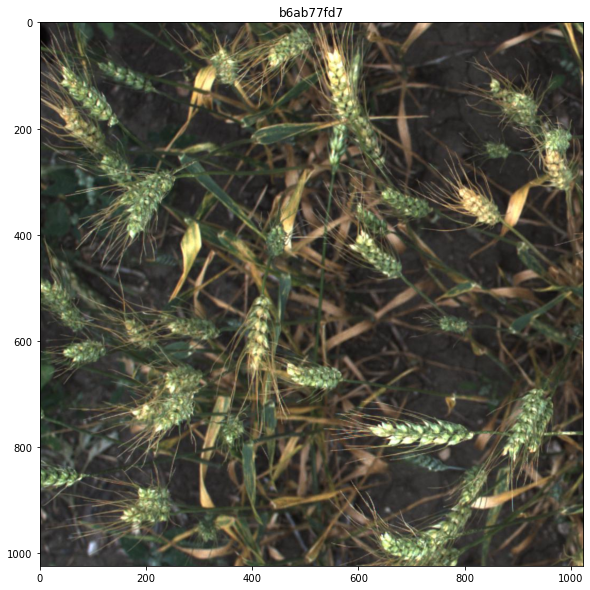

In [28]:

sample_image = "b6ab77fd7"
plt.imshow(read_image_train_folder(sample_image))
_ = plt.title(sample_image)


In [29]:
def bbox_text_parsing(string_input):
    input_without_brackets = re.sub("\[|\]", "", string_input)
    input_as_list = np.array(input_without_brackets.split(","))
    return input_as_list.astype(np.float) 

def xywh_to_x1y1x2y2(x,y,w,h):
    return np.array([x,y,x+w,y+h])

In [30]:
# To parse bounding box labels (training)
df_train = pd.read_csv(os.path.join(DIR_INPUT, "train.csv"))
bbox_series = df_train.bbox.apply(bbox_text_parsing)

df_xywh = pd.DataFrame(bbox_series.to_list(), columns=["x", "y", "w", "h"])

df_x2 = pd.DataFrame(df_xywh.x + df_xywh.w, columns=["x2"])
df_y2 = pd.DataFrame(df_xywh.y + df_xywh.h, columns=["y2"])

df_train = df_train.join([df_xywh, df_x2, df_y2])
df_train.head()

,image_id,width,height,bbox,source,x,y,w,h,x2,y2
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0,890.0,258.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0,356.0,606.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0,451.0,664.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0,943.0,202.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0,150.0,261.0


In [31]:
def draw_boxes(boxes, image, color=(255,0,0)):    
    for box in boxes:
        cv2.rectangle(image,
                      (int(box[0]), int(box[1]) ),
                      (int(box[2]), int(box[3]) ),
                      color, 3)
    return image

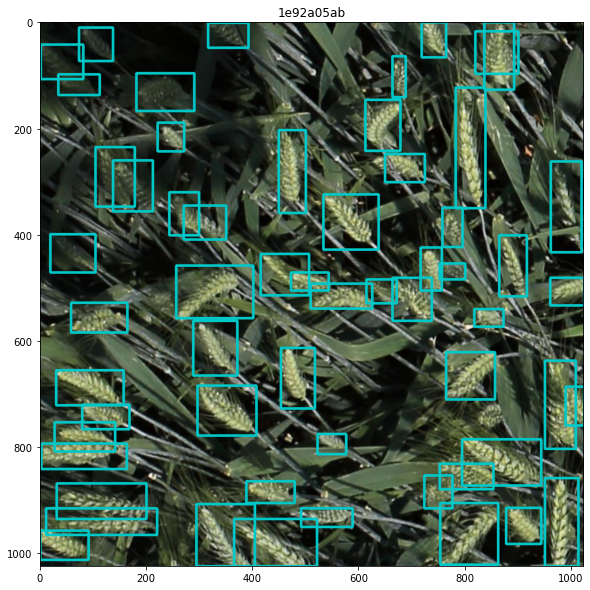

In [32]:
# Sampling a random training instance and drawing bounding boxes on it
sample_image_id =  df_train.image_id.sample().item()

sample_image = read_image_train_folder(sample_image_id)
sample_bboxes = df_train[df_train.image_id == sample_image_id][["x", "y","x2","y2"]]

#plt.figure(figsize=(20,10))
plt.imshow(draw_boxes(sample_bboxes.to_numpy(), sample_image, color=(0,200,200)))
_ = plt.title(sample_image_id)

In [33]:
# Download a pre-trained bounding box detector
model = fasterrcnn_resnet50_fpn(pretrained=True)


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [34]:
model
# Pre-trained on COCO dataset
# out_features = 91, because COCO dataset has 91 classes
# each output has 4 parameters for bounding boxes => 364

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [35]:
# change model output to match our dataset
# we have 2 classes (BACKGROUND, WHEAT)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_channels=in_features, num_classes=2)

# Verify the model architecture
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
)

In [36]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
torch.cuda.empty_cache()
device

device(type='cuda')

In [37]:
def move_batch_to_device(images, targets):
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    return images, targets

In [38]:
# Split data into training and validation subsets
# 80/20 split

unique_image_ids = df_train['image_id'].unique()

validation_split = int(0.2 * len(unique_image_ids))
valid_ids = unique_image_ids[-validation_split:]
train_ids = unique_image_ids[:-validation_split]

validation_df = df_train[df_train['image_id'].isin(valid_ids)]
training_df = df_train[df_train['image_id'].isin(train_ids)]

print("%i training samples\n%i validation samples" % (len(training_df.image_id.unique()),len(validation_df.image_id.unique())) )

2699 training samples
674 validation samples


In [39]:
class WheatDataset(Dataset):

    def __init__(self, dataframe):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe

    def __len__(self) -> int:
        return len(self.image_ids)
    
    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        image = read_image_train_folder(image_id).astype(np.float32)
        
        image /= 255.0
        
        image = torch.from_numpy(image).permute(2,0,1)
        
        records = self.df[self.df['image_id'] == image_id]
        
        boxes = records[['x', 'y', 'x2', 'y2']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        n_boxes = boxes.shape[0]
        
        # there is only one foreground class, WHEAT
        # no need to create label for BACKGROUND class
        labels = torch.ones((n_boxes,), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        
        return image, target

In [40]:
# Create pytorch data loaders for training and validation

train_dataset = WheatDataset(training_df)
valid_dataset = WheatDataset(validation_df)

def collate_fn(batch):
    return tuple(zip(*batch))

is_training_on_cpu = device == torch.device('cpu')
batch_size = 4 if is_training_on_cpu else 16


train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

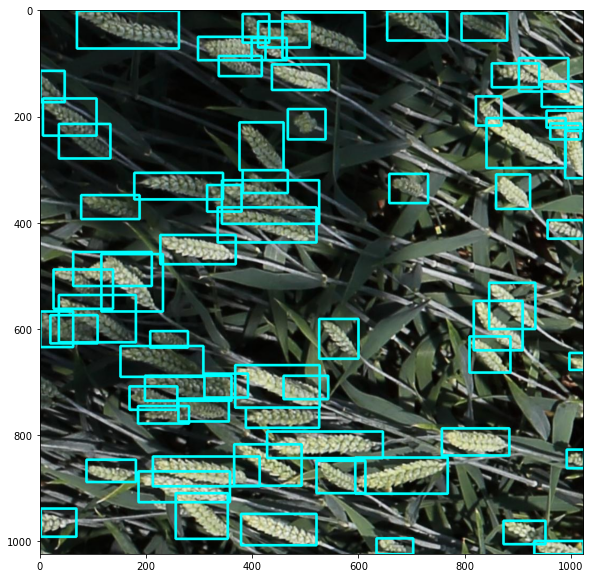

In [41]:
# Test the data loader
batch_of_images, batch_of_targets = next(iter(train_data_loader))

sample_boxes = batch_of_targets[0]['boxes'].cpu().numpy().astype(np.int32)
sample_image = batch_of_images[0].permute(1,2,0).cpu().numpy() # convert back from pytorch format

plt.imshow(draw_boxes(sample_boxes, sample_image, color=(0,200,200)))

In [42]:

optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [43]:
num_epochs = 1 if is_training_on_cpu else 10

# Prepare the model for training
model = model.to(device)
model.train()
    
for epoch in range(num_epochs):
    print("Epoch %i/%i " % (epoch + 1, num_epochs) )
    average_loss = 0
    for batch_id, (images, targets) in enumerate(train_data_loader):
        # Prepare the batch data
        images, targets = move_batch_to_device(images, targets)

        # Calculate losses
        loss_dict = model(images, targets)
        batch_loss = sum(loss for loss in loss_dict.values()) / len(loss_dict)
        
        # Refresh accumulated optimiser state and minimise losses
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        # Record stats
        loss_value = batch_loss.item()
        average_loss = average_loss + (loss_value - average_loss) / (batch_id + 1)
        print("Mini-batch: %i/%i Loss: %.4f" % ( batch_id + 1, len(train_data_loader), average_loss), end='\r')
        if batch_id % 100 == 0:
            print("Mini-batch: %i/%i Loss: %.4f" % ( batch_id + 1, len(train_data_loader), average_loss))

Epoch 1/10 


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Mini-batch: 1/169 Loss: 1.1293
Mini-batch: 101/169 Loss: 0.2608
Epoch 2/10  169/169 Loss: 0.2319
Mini-batch: 1/169 Loss: 0.1865
Mini-batch: 101/169 Loss: 0.1782
Epoch 3/10  169/169 Loss: 0.1761
Mini-batch: 1/169 Loss: 0.1839
Mini-batch: 101/169 Loss: 0.1668
Epoch 4/10  169/169 Loss: 0.1670
Mini-batch: 1/169 Loss: 0.1689
Mini-batch: 101/169 Loss: 0.1628
Epoch 5/10  169/169 Loss: 0.1615
Mini-batch: 1/169 Loss: 0.1572
Mini-batch: 101/169 Loss: 0.1575
Epoch 6/10  169/169 Loss: 0.1576
Mini-batch: 1/169 Loss: 0.1404
Mini-batch: 101/169 Loss: 0.1550
Epoch 7/10  169/169 Loss: 0.1545
Mini-batch: 1/169 Loss: 0.1395
Mini-batch: 101/169 Loss: 0.1523
Epoch 8/10  169/169 Loss: 0.1525
Mini-batch: 1/169 Loss: 0.1493
Mini-batch: 101/169 Loss: 0.1505
Epoch 9/10  169/169 Loss: 0.1502
Mini-batch: 1/169 Loss: 0.1480
Mini-batch: 101/169 Loss: 0.1488
Epoch 10/10 169/169 Loss: 0.1484
Mini-batch: 1/169 Loss: 0.1474
Mini-batch: 101/169 Loss: 0.1474


In [45]:
# Prepare the model for inference
model.eval()

def make_validation_iter():
    valid_data_iter = iter(valid_data_loader)
    for images, targets in valid_data_iter:
        images, targets = move_batch_to_device(images, targets)

        cpu_device = torch.device("cpu")
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        for image, output, target in zip(images, outputs, targets): 
            predicted_boxes = output['boxes'].cpu().detach().numpy().astype(np.int32)
            ground_truth_boxes = target['boxes'].cpu().numpy().astype(np.int32)
            image = image.permute(1,2,0).cpu().numpy()
            yield image, ground_truth_boxes, predicted_boxes

validation_iter = make_validation_iter()

image, ground_truth_boxes, predicted_boxes = next(validation_iter)
image = draw_boxes(predicted_boxes, image, (255,0,0))
image = draw_boxes(ground_truth_boxes, image , (0,255,0))
plt.imshow(image)



NameError: name 'draw_boxes_on' is not defined

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_gwd_finetuned_10_epochs.pth')

